<div style="text-align: center;">
  <img src="https://github.com/Hack-io-Data/Imagenes/blob/main/01-LogosHackio/logo_naranja@4x.png?raw=true" alt="esquema" />
</div>

# Laboratorio: Construcción Modelo de Clasificación y Evaluación de Métricas

Tras realizar el preprocesamiento de los datos y dejarlos listos para construir modelos, ha llegado el momento de dar el siguiente paso: desarrollar tu **primer modelo de clasificación**.

El objetivo de este laboratorio es implementar un modelo de clasificación inicial utilizando **Regresión Logística (Logistic Regression)**. Este modelo te permitirá obtener las primeras predicciones para identificar transacciones normales y anómalas, así como evaluar su desempeño utilizando métricas estándar.

Además, deberás evaluar si el modelo está en riesgo de **overfitting**, asegurando que nuestras predicciones sean consistentes tanto en los datos de entrenamiento como en los de prueba.


## Objetivo del Laboratorio

1. Entrenar un modelo de **Regresión Logística** para predecir si una transacción es "Normal" o "Anómala".

2. Evaluar el desempeño del modelo utilizando métricas como:

   - Precisión (Accuracy).

   - Matriz de confusión.

   - Precisión (Precision), exhaustividad (Recall) y F1-Score.

   - Área bajo la curva ROC (AUC-ROC).

3. Determinar si el modelo presenta **overfitting** o **underfitting**, analizando el rendimiento en los datos de entrenamiento y prueba.


In [430]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

import seaborn as sns
import matplotlib.pyplot as plt

from src.support_logistic import * 

import warnings 
warnings.filterwarnings('ignore')


Cargamos el dataframe a través del pkl.

In [431]:
df = pd.read_pickle("datos/prepped_data.pkl")
df.head()

,is_fraudulent,customer_id,merchant_id,amount,location,purchase_category,customer_age,card_type_American Express,card_type_Discover,card_type_MasterCard,card_type_Visa
0,0,0.779808,0.510079,0.575423,0.389453,0.900628,0.480769,0.0,0.0,1.0,0.0
1,1,0.791454,0.584829,0.189301,0.578321,0.143774,0.826923,0.0,0.0,0.0,1.0
2,1,0.948651,0.463460,0.123960,1.000000,0.900628,0.750000,0.0,0.0,1.0,0.0
3,1,0.791454,0.541243,0.761671,1.000000,0.512530,0.788462,0.0,1.0,0.0,0.0
4,1,0.518519,0.533525,0.188153,0.389453,0.678115,0.346154,0.0,0.0,1.0,0.0


Vamos a separar la variable respuesta de las predictoras, con un sampling del 70%.

In [432]:
X = df.drop(columns = "is_fraudulent")
y = df["is_fraudulent"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Ahora vamos a ejecutar un grid search cross validation con los diferentes parámetros que elegimos. 

In [433]:
parametros_logistic =  [{'penalty': ['l1'], 'solver': ['saga'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'max_iter': [10000]},
    {'penalty': ['l2'], 'solver': ['liblinear'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'max_iter': [10000]},
    {'penalty': ['elasticnet'], 'solver': ['saga'], 'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'max_iter': [10000]},
    {'penalty': ['none'], 'solver': ['lbfgs'], 'max_iter': [10000]}]

regressor = LogisticRegression()

gridsearch = GridSearchCV(estimator = regressor, param_grid=parametros_logistic, cv = 5, scoring = "accuracy")

gridsearch.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10, 100],
                          'max_iter': [10000], 'penalty': ['l1'],
                          'solver': ['saga']},
                         {'C': [0.001, 0.01, 0.1, 1, 10, 100],
                          'max_iter': [10000], 'penalty': ['l2'],
                          'solver': ['liblinear']},
                         {'C': [0.001, 0.01, 0.1, 1, 10, 100],
                          'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
                          'max_iter': [10000], 'penalty': ['elasticnet'],
                          'solver': ['saga']},
                         {'max_iter': [10000], 'penalty': ['none'],
                          'solver': ['lbfgs']}],
             scoring='accuracy')

Nos quedamos con el mejor modelo tras el CV.

In [434]:
best_regressor = gridsearch.best_estimator_

Ahora predeciremos para el train y el test. Además para este caso también tenemos las probabilidades, que indican qué tan probable es que el valor obtenido corresponda a 1. La elección de los valores finales dependerán del threshold (umbral) que escojamos. Cuando

In [435]:
y_train_predict = best_regressor.predict(X = X_train)
y_test_predict = best_regressor.predict(X = X_test)

y_train_predict_prob = best_regressor.predict_proba(X = X_train)[:, 1]
y_test_predict_prob = best_regressor.predict_proba(X = X_test)[:, 1]


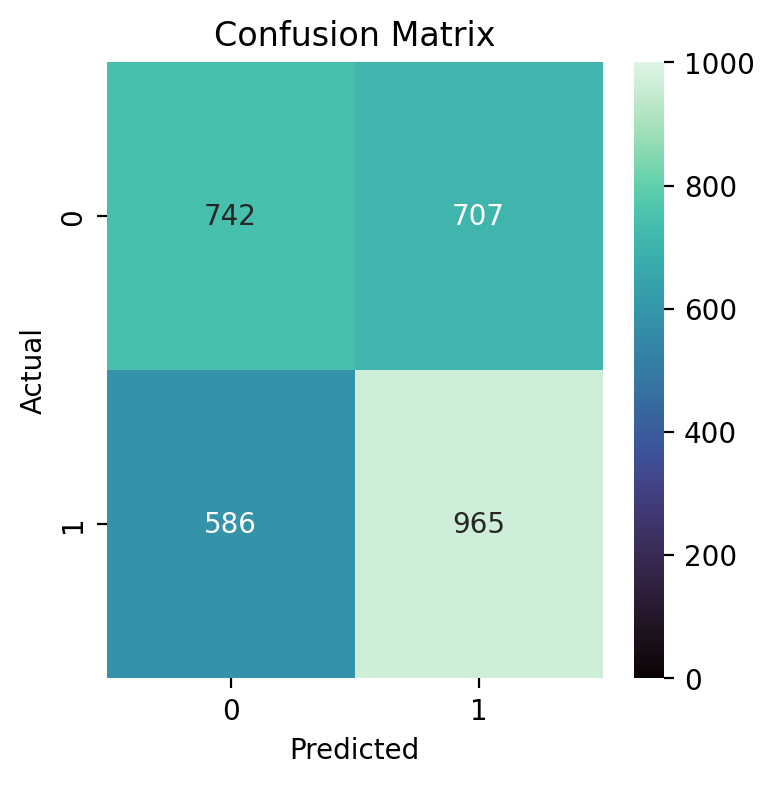

In [528]:
conf_mat = confusion_matrix(y_test, y_test_predict)
plt.figure(figsize = (4,4), dpi = 200)
sns.heatmap(conf_mat, annot=True, fmt="d", vmin=0, vmax=1000, cmap="mako")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [437]:
metricas_regresion = metricas_logisticas(y_train, y_train_predict, y_test, y_test_predict, y_train_predict_prob, y_test_predict_prob)
metricas_regresion

,precision,accuracy,recall,f1_score,kappa,auc
train,0.558303,0.561571,0.609895,0.582960,0.122726,0.584718
test,0.577153,0.569000,0.622179,0.598821,0.134626,0.593959


In [438]:
fpr, tpr, thresholds =  roc_curve(y_test, y_test_predict_prob)

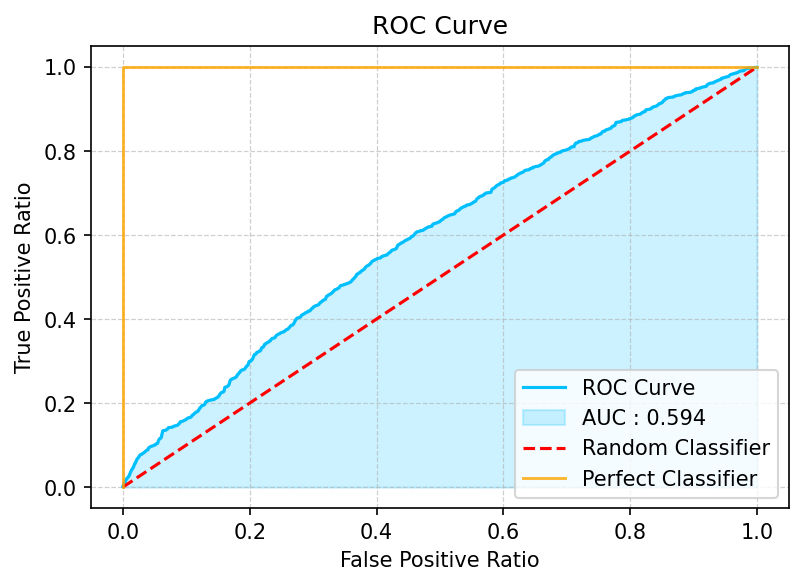

In [530]:
diag = np.linspace(0,1,len(fpr))

plt.figure(figsize=(6,4), dpi = 150)
plt.grid(ls = "--", lw = 0.6, alpha = 0.6)
plt.title("ROC Curve")
sns.lineplot(x = fpr, y = tpr, color = "deepskyblue", label = "ROC Curve")
plt.fill_between(fpr, tpr, color = "deepskyblue", alpha = 0.2, interpolate=False, label = f'AUC : {metricas_regresion.loc["test" ,"auc"]:.3f}')
plt.plot(diag,diag, color = "red", ls = "--", label = "Random Classifier")
plt.plot([0,0,1], [0,1,1], color = "orange", lw = 1.4, alpha = 0.8, label = "Perfect Classifier")
plt.xlabel("False Positive Ratio")
plt.ylabel("True Positive Ratio")
plt.legend()
plt.show()

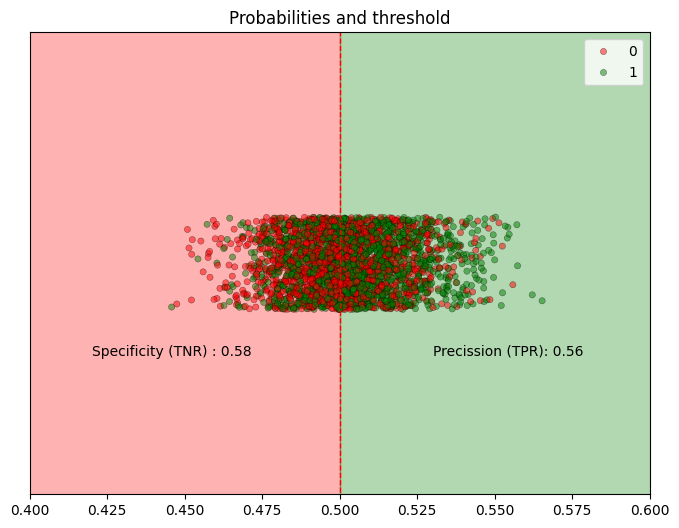

In [481]:
threshold = 0.5
tn = (y_test.iloc[np.where(y_test_predict_prob<=threshold)[0]] == 0).sum()
tp = (y_test.iloc[np.where(y_test_predict_prob>=threshold)[0]] == 1).sum()
all_p = (y_test_predict_prob >= threshold).sum()
all_n = (y_test_predict_prob <= threshold).sum()


plt.figure(dpi = 100, figsize = (8,6))

plt.title("Probabilities and threshold")
plt.fill_between(x = [0,threshold], y1 = 1, y2 = -1, alpha = 0.3, color = "red")
plt.fill_between(x = [threshold, 1], y1 = 1, y2 = -1, alpha = 0.3, color = "green")
plt.vlines(x = threshold, ymin = -1, ymax = 1, ls = "--", color = "red", lw = 1)
sns.scatterplot(
    x=y_test_predict_prob, 
    y=np.zeros_like(y_test_predict_prob) + np.random.uniform(-0.1, 0.1, len(y_test_predict_prob)), 
    hue=y_test,  
    alpha=0.5, 
    s=20, 
    edgecolor="black",
    palette = ["red", "green"]
)
plt.annotate(f"Precission (TPR): {tn/all_n:.2f}", xy = [0.575, 0], xytext = [0.53,-0.2])
plt.annotate(f"Specificity (TNR) : {tp/all_p:.2f}", xy = [0.425, 0], xytext = [0.42,-0.2])
plt.legend()

plt.yticks(ticks=[])
plt.ylim(-0.5,0.5)
plt.xlim(0.4, 0.6)
plt.show()

In [520]:
import numpy as np
import pandas as pd
import plotly.express as px

# Crear dataframe
data = pd.DataFrame({
    "Predicted Probability": y_test_predict_prob,
    "True Label": y_test,
    "True Value": y_test.astype(str),
    "Jitter": np.random.uniform(-0.4, 0.4, len(y_test_predict_prob))
})

# Función para calcular métricas con un threshold dado
def compute_metrics(threshold):
    tn = ((data["Predicted Probability"] <= threshold) & (data["True Label"] == 0)).sum()
    tp = ((data["Predicted Probability"] > threshold) & (data["True Label"] == 1)).sum()
    all_p = (data["Predicted Probability"] > threshold).sum()
    all_n = (data["Predicted Probability"] <= threshold).sum()
    precision = tp / all_p if all_p > 0 else 0
    specificity = tn / all_n if all_n > 0 else 0
    return precision, specificity

# Inicializar el threshold
initial_threshold = 0.5
precision, specificity = compute_metrics(initial_threshold)

# Crear scatterplot con Plotly Express
fig = px.scatter(
    data, 
    x="Predicted Probability", 
    y="Jitter", 
    color="True Value",
    color_discrete_map={"0": "red", "1": "green"},  # Colores personalizados
    opacity=0.6,
    title="Threshold and Metrics"
)



# Añadir áreas sombreadas (zonas roja y verde)
fig.add_shape(
    type="rect",
    x0=0, x1=initial_threshold,
    y0=-1, y1=1,
    fillcolor="red",
    opacity=0.3,
    layer="below",
    line_width=0,
)
fig.add_shape(
    type="rect",
    x0=initial_threshold, x1=1,
    y0=-1, y1=1,
    fillcolor="green",
    opacity=0.3,
    layer="below",
    line_width=0,
)

# Añadir línea vertical inicial
fig.add_vline(
    x=initial_threshold, 
    line_width=2, 
    line_dash="dash", 
    line_color="red",
    annotation_text="",
    annotation_position="top left"
)

# Añadir anotaciones iniciales
fig.add_annotation(
    x=1, y=1.1,
    xref="paper",  # Usar coordenadas relativas al "paper" (el área fuera del gráfico)
    yref="paper",  # Coordenada relativa al "paper" 
    text=f"Precision (TPR): {precision:.3f}", 
    showarrow=False, 
    font=dict(size=14, family = 'Arial Black')
)
fig.add_annotation(
    x=0, y=1.1, 
    xref="paper",  # Usar coordenadas relativas al "paper" (el área fuera del gráfico)
    yref="paper",  # Coordenada relativa al "paper" 
    text=f"Specificity (TNR): {specificity:.3f}", 
    showarrow=False, 
    font=dict(size=14, family = 'Arial Black')
)

# Configurar slider para actualizar threshold
threshold_values = [n for n in np.arange(0.4,0.6,0.001)]

sliders = [dict(
    steps=[
        dict(
            method="relayout",
            args=[
                {
                    # Actualizar línea vertical
                    "shapes[2].x0": t,
                    "shapes[2].x1": t,
                    # Actualizar área roja
                    "shapes[0].x1": t,
                    # Actualizar área verde
                    "shapes[1].x0": t,
                    # Actualizar anotaciones
                    "annotations[1].text": f"Precision (TPR): {compute_metrics(t)[0]:.3f}",
                    "annotations[2].text": f"Specificity (TNR): {compute_metrics(t)[1]:.3f}"
                }
            ],
            label=f"{t:.2f}"
        )
        for t in threshold_values
    ],
    active=0.5,
    currentvalue={"prefix": "Threshold: "},
    pad={"t": 50},
)]

# Añadir slider a la figura
fig.update_layout(sliders=sliders)
fig.update(layout_coloraxis_showscale=False)

fig.update_layout(
    xaxis=dict(
        range=[0.4, 0.6],  # Cambiar el rango del eje X
    ),
    yaxis=dict(
        range=[-0.8, 0.8],  # Cambiar el rango del eje X
        showticklabels=False
    ),
    yaxis_title=None
)

# Mostrar gráfica interactiva
fig.show()
